# Evaluating the Model

### Install Requirements

In [1]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl

### Import Required Libraries

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import fiftyone as fo
import cv2
import matplotlib.pyplot as plt
import PIL
import requests

from pathlib import Path
from PIL import Image, ImageOps, ImageDraw, ImageFont
from PIL.ExifTags import TAGS
from pyzbar.pyzbar import decode, ZBarSymbol
from torchvision import transforms
from torchvision.ops import box_convert
from IPython.display import display
import argparse
import copy
from io import BytesIO

from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv
from segment_anything import build_sam, SamPredictor
from diffusers import StableDiffusionInpaintPipeline
from huggingface_hub import hf_hub_download
from pycocotools.coco import COCO

# Set up the logger for detectron2
setup_logger()


/opt/conda/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


<Logger detectron2 (DEBUG)>

### Load Grounding Dino Model


In [5]:


def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model


ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/jovyan/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [6]:
TEXT_PROMPT = "leaf"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

### Load SAM Model

In [7]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-06-12 18:13:54--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.80, 18.155.173.79, 18.155.173.40, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   102MB/s    in 23s     

2024-06-12 18:14:18 (106 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

### Specify Model

There are several output folders from training multiple models.  

In [3]:
# set this to today's date
today = "2024-03-15"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder_name = today + "_" + suffix

data_path = '/home/jovyan/work/data/2024-03-14_leaves'
output_folder = f'/home/jovyan/work/mask_rcnn/{output_folder_name}'
coco_annotation_folder = '/home/jovyan/work/data/2024-03-14_leaves_rotated.json'

k=5

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [ ]:
import numpy as np

# Usually there is a mask for the entire plant in addition to individual leaves. 
# This function attempts to remove the full plant mask by caclculating the iou of each mask and the union of all masks.
def check_full_plant(masks):
    # Initialize the combined mask
    mask_all = np.zeros(masks[0].shape, dtype=np.float32)

    # Combine all masks into one
    for mask in masks:
        mask_all += mask.astype(np.float32)

    iou_withall = []
    # Calculate IoU for each mask with the combined mask
    for mask in masks:
        iou_withall.append(iou(mask, mask_all > 0))

    idx_notall = np.array(iou_withall) < 0.9
    return idx_notall

def annotate_masks_in_image(masks, image, include, random_color=True):
    # Convert image to RGBA
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    
    # print(masks.shape[0])
    
    # Iterate through each mask
    for i in range(masks.shape[0]):
        if (include[i]):
            # print(masks[i])
            mask = masks[i]
            if random_color:
                color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
            else:
                color = np.array([30/255, 144/255, 255/255, 0.6])

            h, w = mask.shape[-2:]
            mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

            mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

            # Composite the mask with the image
            annotated_frame_pil = Image.alpha_composite(annotated_frame_pil, mask_image_pil)
    
    return np.array(annotated_frame_pil)

In [4]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo

sam_image_dir = '2024-06-04_cropped'
sam_output_folder = '/home/jovyan/work/data/grounded_sam/leaf_full_dataset'

# Assuming leaf_predictor is defined elsewhere and dataset is an iterable of samples
datasets = {}

# 
for fold in range(0, 5):
    
    base_path = f"{output_folder}/fold_{fold}/"

    leaf_cfg = get_cfg()
    leaf_cfg.MODEL.DEVICE='cpu'
    leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
    leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

    leaf_predictor = DefaultPredictor(leaf_cfg)
    
    print(f'Loading fold {fold} into fiftyone dataset...')
    
    datasets[f'fold_{fold}'] = fo.Dataset.from_dir(
        data_path=f"{data_path}",
        labels_path=f"{output_folder}/test_{fold}.json",
        dataset_type=fo.types.COCODetectionDataset, 
        name=f"{today}_fold_{fold}",
        label_types="segmentations",
        overwrite=True
    )
    
    print(f'Performing inference for fold {fold}...')

    with fo.ProgressBar() as pb:
        for sample in pb(datasets[f'fold_{fold}']):
            image = Image.open(sample.filepath)
            image = ImageOps.exif_transpose(image)  # Ensure correct orientation
            image_arr = np.array(image)
            h, w, _ = image_arr.shape

            
            ## --------------- MASK-RCNN ----------------
            
            outputs = leaf_predictor(image_arr)

            # Initialize counters for each class
            red_square_pixels, leaf_pixels, qr_pixels = 0, 0, 0
            mask_rcnn_detections = []

            for i, (mask, box, label, score) in enumerate(zip(outputs["instances"].pred_masks.numpy(),
                                                              outputs["instances"].pred_boxes.tensor.numpy(),
                                                              outputs["instances"].pred_classes.numpy(),
                                                              outputs["instances"].scores.numpy())):
                x1, y1, x2, y2 = box
                rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]  # Relative bounding box

                bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
                mask_pixel_count = np.count_nonzero(bbox_mask)

                class_label = ['leaf', 'qr', 'red-square'][label]

                # Update pixel counts based on class
                if class_label == 'leaf':
                    leaf_pixels += mask_pixel_count
                elif class_label == 'red-square':
                    red_square_pixels += mask_pixel_count  # Assuming you want to sum red square pixels
                elif class_label == 'qr':
                    qr_pixels += mask_pixel_count

                mask_rcnn_detections.append(fo.Detection(
                    label=class_label,
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                ))

            # print(f'image: {sample.filepath}, red_square_pixels: {red_square_pixels}, leaf_pixels: {leaf_pixels}, qr_pixels: {qr_pixels}')

            # Calculate leaf area
            leaf_area = None
            if red_square_pixels:
                # Red square is 2cm x 2cm, or 4 cm2
                leaf_area = (4 * leaf_pixels) / red_square_pixels
            elif qr_pixels:
                 # QR is 1.2cm x 1.2cm, or 1.44 cm2
                leaf_area = (1.44 * leaf_pixels) / qr_pixels

                
            
            # --------------------- Grounding Dino  --------------------
            
            
             boxes, logits, phrases = predict(
                model=groundingdino_model, 
                image=image, 
                caption=TEXT_PROMPT, 
                box_threshold=BOX_TRESHOLD, 
                text_threshold=TEXT_TRESHOLD,
                device=DEVICE
            )
                
            # these lines create an image annotated with bounding boxes of Grounding Dino predictions
            annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
            annotated_frame = annotated_frame[...,::-1] # BGR to RGB
            dino_result = Image.fromarray(annotated_frame)
            # output_image.save(f"{output_folder}/{name}_dino.png")

            # set image
            sam_predictor.set_image(image_source)

            # box: normalized box xywh -> unnormalized xyxy
            H, W, _ = image_source.shape
            boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

            transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
            masks, _, _ = sam_predictor.predict_torch(
                point_coords = None,
                point_labels = None,
                boxes = transformed_boxes,
                multimask_output = False,
            )

            annotated_frame_with_mask = None

            masks_cpu = masks.cpu().numpy()
            idx_not_full_plant = checkfullplant(masks_cpu)
            # print(idx_notall)

            original_image = Image.open(file_path)
            image_array = np.array(original_image)
            annotated_frame_with_mask = annotate_masks_in_image(
                masks_cpu,
                image_array,
                idx_not_full_plant
            )
            output_image = Image.fromarray(annotated_frame_with_mask)
            # output_image.save(f"{output_folder}/{name}_final.png")
            
            grounded_sam_detections = []
            
            # Add Grounded SAM to FiftyOne dataset
            for i in range(masks.shape[0]):
                if (idx_not_full_plant[i]):
                    mask = masks[i]
                    grounded_sam_detections.append(fo.Detection(
                        label=class_label,
                        bounding_box=rel_box,
                        mask=bbox_mask,
                        confidence=score,
                        original_bbox=box
                    ))
            
            
            
            

            # Update sample with detections and calculated area
            sample["predictions"] = fo.Detections(detections=mask_rcnn_detections)
            sample["grounded_sam_predictions"] = fo.Detections(detections=grounded_sam_detections)
            sample["red_square_pixels"] = red_square_pixels
            sample["qr_pixels"] = qr_pixels
            sample["height"] = h
            sample["width"] = w
            sample["area"] = leaf_area
            sample.tags.append(os.path.basename(sample.filepath))
            sample.save()


[06/10 16:30:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/fold_0/model_final.pth ...
Loading fold 0 into fiftyone dataset...
Migrating database to v0.24.0
 100% |███████████████████| 36/36 [10.1s elapsed, 0s remaining, 3.4 samples/s]     
Performing inference for fold 0...
   0% ||------------------|  0/36 [10.4ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 100% |███████████████████| 36/36 [1.1m elapsed, 0s remaining, 0.5 samples/s]     
[06/10 16:32:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/fold_1/model_final.pth ...
Loading fold 1 into fiftyone dataset...
 100% |███████████████████| 35/35 [8.5s elapsed, 0s remaining, 4.0 samples/s]      
Performing inference for fold 1...
 100% |███████████████████| 35/35 [1.0m elapsed, 0s remaining, 0.6 samples/s]     
[06/10 16:33:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/fold_2/model_final.pth ...
Loading fold 2 into fiftyone dataset...
 100% |███████████████████| 35/35 [9.0s elapsed, 0s remaining, 3.2 samples/s]      
Performing inference for fold 2...
 100% |███████████████████| 35/35 [1.1m elapsed, 0s remaining, 0.5 samples/s]     
[06/10 16:34:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/j

IMG_5858
Precision:  1.0
Recall:  0.5
Num matches: 1


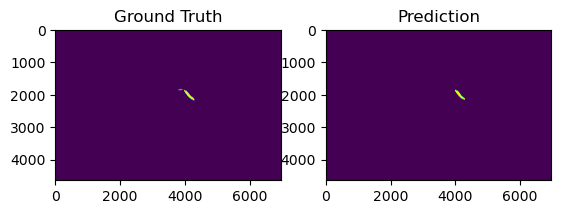

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_pixels(bbox, height, width):
    x1, y1, w, h = bbox
    return [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

def calculate_mask(detections, height, width):
    mask = np.zeros((height, width), dtype=bool)
    for d in detections:
        if d.label == 'leaf':
            bbox = d.bounding_box
            x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
            mask[round(y1):round(y2), round(x1):round(x2)] |= d.mask
    return mask

def calculate_iou_and_dice(gt_mask, pred_mask):
    # if np.count_nonzero(gt_mask) == 0 and np.count_nonzero(pred_mask) == 0:
    #     # Perfect agreement in the absence of objects
    #     return 1, 1
    
    intersect = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    # Normal IoU and Dice calculation when there are objects
    iou = intersect_pixels / union_pixels if union_pixels else None
    dice = (2 * intersect_pixels) / (np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask)) if np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask) else None
    
    return iou, dice

def visualize_masks(gt_mask, pred_mask):
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')
    axarr[0].imshow(gt_mask)
    axarr[1].imshow(pred_mask)
    plt.show()
    

def calculate_precision_recall(ground_truths, predictions, iou_threshold=0.5):
    matches = []
    matched_gt_indices = set()  # To track which ground_truths are matched

    # Matching detections between predictions and ground_truths
    for pred in predictions:
        best_iou = 0
        best_match_index = None
        for index, gt in enumerate(ground_truths):
            print(gt['bounding_box'], pred['bounding_box'])
            iou, dice = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])
            if iou > best_iou:
                best_iou = iou
                best_match_index = index
        if best_iou >= iou_threshold:
            matches.append((pred, ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(predictions) - true_positives
    false_negatives = len(ground_truths) - len(matched_gt_indices)  # Ground truths not matched

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches)

def calculate_pixel_level_precision_recall(gt_mask, pred_mask):
    TP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 1))
    FP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 0))
    FN = np.sum(np.logical_and(pred_mask == 0, gt_mask == 1))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall


def calculate_precision_recall_count(ground_truths, predictions, iou_threshold=0.5):
    # Filter detections to include only those with the label 'leaf'
    filtered_ground_truths = [gt for gt in ground_truths if gt['label'] == 'leaf']
    filtered_predictions = [pred for pred in predictions if pred['label'] == 'leaf']

    matches = []
    matched_gt_indices = set()  # Tracks which ground_truths are matched

    # Matching detections between filtered predictions and filtered ground_truths
    for pred_index, pred in enumerate(filtered_predictions):
        best_iou = 0
        best_match_index = None
        for gt_index, gt in enumerate(filtered_ground_truths):
            if gt_index in matched_gt_indices:
                continue  # Skip already matched ground truths
            # print(gt)
            iou, _ = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])  # Dice can be ignored if not needed
            if iou > best_iou:
                best_iou = iou
                best_match_index = gt_index
        
        if best_iou >= iou_threshold:
            matches.append((pred, filtered_ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(filtered_predictions) - true_positives
    false_negatives = len(filtered_ground_truths) - len(matched_gt_indices)
    


    # Keep the original print statements
    # print('True positives: ', true_positives)
    # print('False positives: ', false_positives)
    # print('False negatives: ', false_negatives)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches), true_positives, false_positives, false_negatives



dataset_1 = datasets['fold_0']
# print(dataset_1)
sample = dataset_1.first()
height, width = sample.height, sample.width
ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
prediction_mask = calculate_mask(sample.predictions.detections, height, width)
filename = sample.filepath.split('/')[-1].split('.')[0]
print(filename)
precision, recall, num_matches, tp, fp, fn = calculate_precision_recall_count(sample.ground_truth.detections, sample.predictions.detections)
print('Precision: ', precision)
print('Recall: ', recall)
print('Num matches:', num_matches)

visualize_masks(ground_truth_mask, prediction_mask)
    

In [8]:
def count_leaves(detections):
    return sum(1 for d in detections if hasattr(d, 'label') and d.label == 'leaf')

In [10]:
import pandas as pd

# initialize dataframe from manual area file, and add column for ml_area
df = pd.read_excel('/home/jovyan/work/data/manual_area_count.xlsx')

columns_to_initialize = ['ml_area', 'ml_leaf_count', 'ground_truth_pixels', 'prediction_pixels', 'iou', 'dice', 'count_precision', 'count_recall', 'num_matches', 'tp', 'fp', 'fn',  'mask_precision', 'mask_recall']

# Initialize columns to None and then convert to float
for column in columns_to_initialize:
    df[column] = None
    df[column] = df[column].astype(float)

df['fold'] = "fold"
    
missing_from_file = []

for fold_name, dataset in datasets.items():
    
    print('\n' + fold_name)
    print('---------------------------')
    
    fold_iou = []
    fold_dice = []

    for sample in dataset:

        filename = sample.filepath.split('/')[-1].split('.')[0]

        if not df.loc[df['picture'].str.startswith(filename)].empty:
            df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2))
            df.loc[df['picture'].str.startswith(filename), 'ml_leaf_count'] = count_leaves(sample.predictions.detections)
        else:
            missing_from_file.append(filename)
        
        height, width = sample.height, sample.width
        ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
        prediction_mask = calculate_mask(sample.predictions.detections, height, width)
        precision, recall, matches, tp, fp, fn = calculate_precision_recall_count(sample.ground_truth.detections, sample.predictions.detections)

        print(filename)

        iou, dice = calculate_iou_and_dice(ground_truth_mask, prediction_mask)
        pixel_precision, pixel_recall = calculate_pixel_level_precision_recall(ground_truth_mask, prediction_mask)
        # print(pixel_precision,  pixel_recall)
 
        
        # print(dice)
        row = df['picture'].str.startswith(filename)
        
        df.loc[row, 'ground_truth_pixels'] = np.count_nonzero(ground_truth_mask)
        df.loc[row, 'prediction_pixels'] = np.count_nonzero(prediction_mask)
        df.loc[row, 'iou'] = round(iou, 3) if iou is not None else None
        df.loc[row, 'dice'] = round(dice, 3) if dice is not None else None
        df.loc[row, 'count_precision'] = round(precision, 3)
        df.loc[row, 'count_recall'] = round(recall, 3)
        df.loc[row, 'num_matches'] = matches  
        df.loc[row, 'tp'] = tp  
        df.loc[row, 'fp'] = fp  
        df.loc[row, 'fn'] = fn
        df.loc[row, 'fold'] = fold_name
        df.loc[row, 'mask_precision'] = pixel_precision
        df.loc[row, 'mask_recall'] = pixel_recall
        
        fold_iou.append(iou)
        fold_dice.append(dice)

        # visualize_masks(ground_truth_mask, prediction_mask)
    
    fold_iou = np.array(fold_iou, dtype=float)
   

    print('Min IOU: ', np.nanmin(fold_iou))
    print('Max IOU: ', np.nanmax(fold_iou))
    print('Average IOU: ', np.nanmean(fold_iou))

    print('\n')
    fold_dice = np.array(fold_dice, dtype=float)
    print('Min Dice: ', np.nanmin(fold_dice))
    print('Max Dice: ', np.nanmax(fold_dice))
    print('Average Dice: ', np.nanmean(fold_dice))


df_area = df[df['ml_area'] >= 0.0]
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)

# Calculate means for specific columns
mean_values = {
    'ground_truth_pixels': None,
    'prediction_pixels': None,
    'iou': np.nanmean(df['iou']),
    'dice': np.nanmean(df['dice']),
    'count_precision': df['count_precision'].mean(),
    'count_recall': df['count_recall'].mean(),
    'mask_precision': df['mask_precision'].mean(),
    'mask_recall': df['mask_recall'].mean(),
    'num_matches': None,
}

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_values, index=['average'])

# Append the new DataFrame with averages to the original DataFrame
df = pd.concat([df, mean_df])


# Specify the path and name of the CSV file you want to create
csv_file_path = f'{output_folder}/{output_folder_name}.csv'

# Export the DataFrame to CSV
df.to_csv(csv_file_path, index=False)



fold_0
---------------------------
IMG_5858
IMG_5869
IMG_5871
IMG_5879
IMG_5908
IMG_5918
IMG_5924
IMG_5951
IMG_5957
IMG_5958
IMG_5959
IMG_5962
IMG_5970
IMG_5973
IMG_5976
IMG_5984
IMG_5985
IMG_5990
IMG_5993
IMG_5997
IMG_5998
IMG_6000
IMG_6001
IMG_6002
IMG_6008
IMG_6009
IMG_6010
IMG_6019
IMG_6035
IMG_6037
IMG_6039
IMG_6041
IMG_6043
IMG_6047
IMG_6050
IMG_6055
Min IOU:  0.0
Max IOU:  0.9209818733342169
Average IOU:  0.8001099079315748


Min Dice:  0.0
Max Dice:  0.9588657614303082
Average Dice:  0.8733114246673911

fold_1
---------------------------
IMG_5850
IMG_5856
IMG_5862
IMG_5873
IMG_5874
IMG_5875
IMG_5910
IMG_5913
IMG_5914
IMG_5919
IMG_5922
IMG_5925
IMG_5933
IMG_5935
IMG_5936
IMG_5937
IMG_5938
IMG_5939
IMG_5947
IMG_5953
IMG_5955
IMG_5968
IMG_5969
IMG_5971
IMG_5972
IMG_5978
IMG_5987
IMG_5995
IMG_6016
IMG_6024
IMG_6027
IMG_6028
IMG_6034
IMG_6040
IMG_6042
Min IOU:  0.05878360032582134
Max IOU:  0.9161186977295381
Average IOU:  0.7398930593775834


Min Dice:  0.1110398769072958
Max Dice

R2:  0.9876426066281181
p:  6.044334905083657e-168


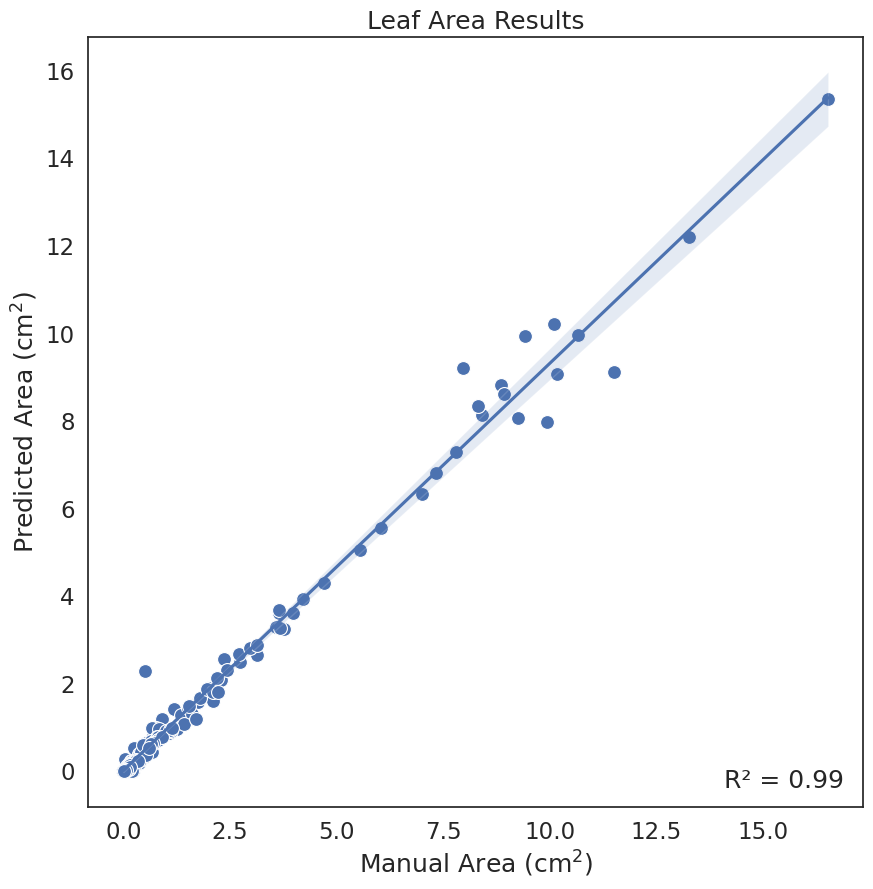

In [56]:

# plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
# plt.set(xlabel='Manual Area', ylabel='Predicted Area')
# plt.set(title="Leaf Area Results (cm$^{2}$)")
# plt.savefig("leaf_area.png", dpi=300)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

count_r, count_p = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
count_r_squared = count_r**2
print('R2: ', count_r_squared)
print('p: ', count_p)

sns.set(style="white", palette=None, font_scale=1.5)

# Create scatter plot
sns.scatterplot(data=df_area, x='area_cm2', y='ml_area', s=100)

# Add regression line
sns.regplot(data=df_area, x='area_cm2', y='ml_area', scatter=False)

# Customize plot labels and title
plt.xlabel('Manual Area (cm$^{2}$)')
plt.ylabel('Predicted Area (cm$^{2}$)')
plt.title('Leaf Area Results')

# # Annotate points
ax = plt.gca()
# for line in range(0, df_area.shape[0]):
#     ax.text(df_area.Leaves[line] + 0.01, df_area.ml_leaf_count[line], 
#             df_area.picture[line], horizontalalignment='left', 
#             size='medium', color='purple', weight='semibold')

# Annotate R-squared value
ax.text(0.82, 0.05, f'R² = {count_r_squared:.2f}', transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='left', 
        bbox=dict(facecolor='white', alpha=0.5))


# Save the plot
plt.savefig("leaf_area.png", dpi=300)

# Show the plot
plt.show()


R2:  0.9878236277623764
p:  7.085922612999256e-160


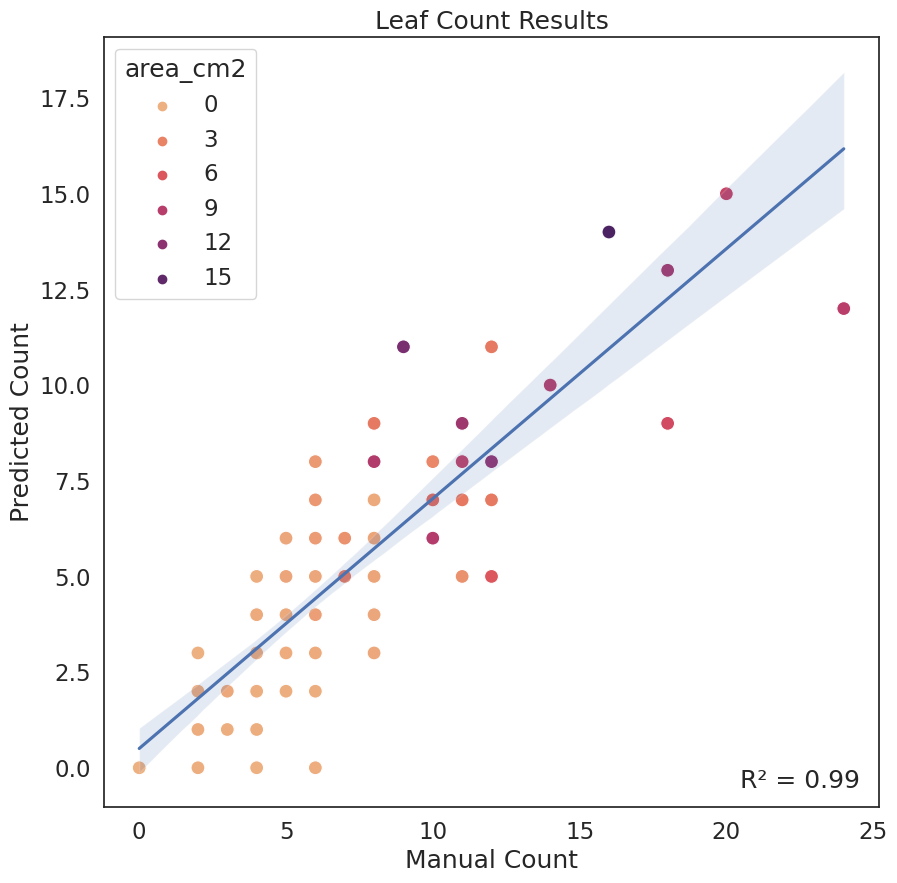

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df_area_count = df_area.dropna(subset=['Leaves', 'ml_leaf_count'])
count_r, count_p = stats.pearsonr(df_area_count.area_cm2, df_area_count.ml_area)

count_r_squared = count_r**2
print('R2: ', count_r_squared)
print('p: ', count_p)

sns.set(style="white", palette=None, font_scale=1.5)

# Create scatter plot
sns.scatterplot(data=df_area_count, x='Leaves', y='ml_leaf_count', s=100, hue='area_cm2', palette=sns.color_palette("flare", as_cmap=True))

# Add regression line
sns.regplot(data=df_area, x='Leaves', y='ml_leaf_count', scatter=False)

# Customize plot labels and title
plt.xlabel('Manual Count')
plt.ylabel('Predicted Count')
plt.title('Leaf Count Results')

# # Annotate points
ax = plt.gca()
# for line in range(0, df_area.shape[0]):
#     ax.text(df_area.Leaves[line] + 0.01, df_area.ml_leaf_count[line], 
#             df_area.picture[line], horizontalalignment='left', 
#             size='medium', color='purple', weight='semibold')

# Annotate R-squared value
ax.text(0.82, 0.05, f'R² = {count_r_squared:.2f}', transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='left', 
        bbox=dict(facecolor='white', alpha=0.5))


# Save the plot
plt.savefig("leaf_count.png", dpi=300)

# Show the plot
plt.show()

In [46]:
df_area.corr(numeric_only=True)

,area_cm2,Unnamed: 2,Leaves,ml_area,ml_leaf_count,ground_truth_pixels,prediction_pixels,iou,dice,count_precision,count_recall,num_matches,tp,fp,fn,mask_precision,mask_recall
area_cm2,1.000000,NaN,0.747964,0.993802,0.732871,0.959802,0.949654,0.320556,0.259220,0.138091,0.101896,0.732871,0.743293,0.109309,0.462299,0.225182,0.260910
Unnamed: 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Leaves,0.747964,NaN,1.000000,0.764713,0.839626,0.646200,0.638214,0.345216,0.299336,0.281003,0.217313,0.839626,0.859279,0.086993,0.439388,0.348588,0.378128
ml_area,0.993802,NaN,0.764713,1.000000,0.754797,0.953539,0.948476,0.313470,0.251270,0.136031,0.125180,0.754797,0.762192,0.131579,0.432741,0.214052,0.273775
ml_leaf_count,0.732871,NaN,0.839626,0.754797,1.000000,0.668021,0.666070,0.519646,0.467740,0.359449,0.499667,1.000000,0.985948,0.310053,0.250430,0.460105,0.577993
ground_truth_pixels,0.959802,NaN,0.646200,0.953539,0.668021,1.000000,0.995849,0.341459,0.274337,0.138339,0.143859,0.668021,0.671337,0.134823,0.321293,0.234096,0.279075
prediction_pixels,0.949654,NaN,0.638214,0.948476,0.666070,0.995849,1.000000,0.329410,0.260539,0.129454,0.162490,0.666070,0.664662,0.161262,0.290617,0.214230,0.291311
iou,0.320556,NaN,0.345216,0.313470,0.519646,0.341459,0.329410,1.000000,0.977284,0.666274,0.545118,0.519646,0.545470,-0.024943,-0.020832,0.830594,0.842474
dice,0.259220,NaN,0.299336,0.251270,0.467740,0.274337,0.260539,0.977284,1.000000,0.782893,0.548960,0.467740,0.495495,-0.046637,-0.023368,0.901329,0.826544
count_precision,0.138091,NaN,0.281003,0.136031,0.359449,0.138339,0.129454,0.666274,0.782893,1.000000,0.592299,0.359449,0.410440,-0.207499,0.165782,0.926381,0.796005


In [33]:
from scipy import stats

corr, p_value = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print('R: ', corr)
print('p: ', p_value)
# r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

R:  0.9938020963089774
p:  6.044334905083657e-168
r^2: 0.9876426066281181


In [31]:
df_area.corr(method='pearson', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice,count_precision,count_recall,num_matches,tp,fp,fn,mask_precision,mask_recall
area_cm2,1.000000,0.993802,0.959802,0.949654,0.320556,0.259220,0.138091,0.101896,0.732871,0.743293,0.109309,0.462299,0.225182,0.260910
ml_area,0.993802,1.000000,0.953539,0.948476,0.313470,0.251270,0.136031,0.125180,0.754797,0.762192,0.131579,0.432741,0.214052,0.273775
ground_truth_pixels,0.959802,0.953539,1.000000,0.995849,0.341459,0.274337,0.138339,0.143859,0.668021,0.671337,0.134823,0.321293,0.234096,0.279075
prediction_pixels,0.949654,0.948476,0.995849,1.000000,0.329410,0.260539,0.129454,0.162490,0.666070,0.664662,0.161262,0.290617,0.214230,0.291311
iou,0.320556,0.313470,0.341459,0.329410,1.000000,0.977284,0.666274,0.545118,0.519646,0.545470,-0.024943,-0.020832,0.830594,0.842474
dice,0.259220,0.251270,0.274337,0.260539,0.977284,1.000000,0.782893,0.548960,0.467740,0.495495,-0.046637,-0.023368,0.901329,0.826544
count_precision,0.138091,0.136031,0.138339,0.129454,0.666274,0.782893,1.000000,0.592299,0.359449,0.410440,-0.207499,0.165782,0.926381,0.796005
count_recall,0.101896,0.125180,0.143859,0.162490,0.545118,0.548960,0.592299,1.000000,0.499667,0.458540,0.349032,-0.417834,0.592714,0.824430
num_matches,0.732871,0.754797,0.668021,0.666070,0.519646,0.467740,0.359449,0.499667,1.000000,0.985948,0.310053,0.250430,0.460105,0.577993
tp,0.743293,0.762192,0.671337,0.664662,0.545470,0.495495,0.410440,0.458540,0.985948,1.000000,0.146879,0.307211,0.487706,0.569247


In [32]:
df_area.corr(method='kendall', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice,count_precision,count_recall,num_matches,tp,fp,fn,mask_precision,mask_recall
area_cm2,1.000000,0.895792,0.928251,0.890899,0.467974,0.467796,0.130142,0.189860,0.693628,0.718486,0.104673,0.156365,0.388826,0.368853
ml_area,0.895792,1.000000,0.876594,0.926318,0.495842,0.495979,0.109958,0.249061,0.741934,0.754479,0.156061,0.111343,0.359574,0.441396
ground_truth_pixels,0.928251,0.876594,1.000000,0.926768,0.493439,0.493433,0.152382,0.207370,0.681029,0.703174,0.095546,0.149102,0.409257,0.387255
prediction_pixels,0.890899,0.926318,0.926768,1.000000,0.507516,0.507525,0.117518,0.253718,0.706165,0.717617,0.144752,0.103333,0.368003,0.448941
iou,0.467974,0.495842,0.493439,0.507516,1.000000,0.998586,0.098553,0.226951,0.473910,0.507831,0.010003,-0.052298,0.404488,0.656270
dice,0.467796,0.495979,0.493433,0.507525,0.998586,1.000000,0.099188,0.227056,0.474145,0.508406,0.009443,-0.052274,0.403816,0.658144
count_precision,0.130142,0.109958,0.152382,0.117518,0.098553,0.099188,1.000000,-0.092916,0.022625,0.138297,-0.706589,0.411275,0.348118,0.060089
count_recall,0.189860,0.249061,0.207370,0.253718,0.226951,0.227056,-0.092916,1.000000,0.402880,0.350811,0.409006,-0.665162,-0.026054,0.425649
num_matches,0.693628,0.741934,0.681029,0.706165,0.473910,0.474145,0.022625,0.402880,1.000000,0.959265,0.287318,0.002126,0.309826,0.442262
tp,0.718486,0.754479,0.703174,0.717617,0.507831,0.508406,0.138297,0.350811,0.959265,1.000000,0.149407,0.062560,0.349501,0.430236


In [8]:
session = fo.launch_app(datasets['fold_0'], port=5151, address="0.0.0.0")


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [29]:
session.refresh()

In [ ]:
results = df_area[df_area['ml_area'] >= 0.0]
results
mask = results['dice'] < .2

# Step 2: Calculate the percentage of samples meeting the condition
percentage = (mask.sum() / len(results)) * 100

print(f"Percentage of samples with dice score > 90: {percentage}%")